## Training an RNN to do binary addition

In [1]:
from __future__ import print_function, division, absolute_import

In [2]:
import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Generating data

In [4]:
def generate_instance(bin_size=8, a=None, b=None):
    max_int = 2 ** bin_size - 1
    int2bin = lambda n: np.array([int(i) for i in np.binary_repr(n, bin_size)], dtype=np.int32)
    
    a = np.random.randint(0, max_int // 2) if a is None else a
    x1 = int2bin(a)
    
    b = np.random.randint(0, max_int // 2) if b is None else b
    x2 = int2bin(b)
    
    c = a + b
    y = int2bin(c)
    return x1,x2,y

In [5]:
def generate_batch(batch_size=100, bin_size=8):
    X = np.zeros(shape=[batch_size, bin_size, 2], dtype=np.int32)
    Y = np.zeros(shape=(batch_size, bin_size), dtype=np.int32)
    for i in range(batch_size):
        x1,x2,y = generate_instance(bin_size)
        X[i,:,0] = x1
        X[i,:,1] = x2
        Y[i,:] = y
    return X, Y

In [6]:
def ints2bins(ints, bin_size=8, concatenate=False):
    if concatenate:
        X = np.zeros([len(ints)**2, bin_size*2])
    else:
        X = np.zeros([len(ints)**2, bin_size, 2])
    
    Y = np.zeros([len(ints)**2, bin_size])
    
    for i, a in enumerate(ints):
        for j, b in enumerate(ints):
            row_idx = i+j
            x1,x2,y = generate_instance(bin_size, a, b)
            if concatenate:
                X[row_idx,:] = np.concatenate((x1,x2))
            else:
                X[row_idx,:,0] = x1
                X[row_idx,:,1] = x2
            Y[row_idx,:] = y
    return X,Y

In [7]:
# This is if we want to make test instances that never appeared in the training set
def generate_train_test_set(bin_size=8, test_ratio=0.2, concatenate=False):
    max_int = 2 ** (bin_size-1)
    
    test_ints = np.random.choice(range(max_int), int(test_ratio*max_int), replace=False)
    train_ints = [i for i in range(max_int) if i not in test_ints]
    
    train_X, train_Y = ints2bins(train_ints, bin_size, concatenate)
    test_X, test_Y = ints2bins(test_ints, bin_size, concatenate)
    
    return train_X, train_Y, test_X, test_Y

### 100 integers are used for training
### The other 28 ones are used for testing

## First: Linear Regression
<img src="http://www.biostathandbook.com/pix/regressionlollipop.gif">

In [8]:
seed = 48
bin_size=8
hidden_size = 16

np.random.seed(seed)

In [9]:
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(seed)
    train_x = tf.placeholder(tf.float32, shape=[None,bin_size*2])
    train_y = tf.placeholder(tf.float32, shape=[None, bin_size])
    
    w = tf.Variable(tf.random_normal(shape=[bin_size*2, bin_size]))
    b = tf.Variable(tf.zeros(shape=[bin_size]))
    
    def model(data):
        return tf.nn.sigmoid(tf.add(tf.matmul(data,w),b))
    
    pred = model(train_x)
    loss = tf.reduce_mean(tf.norm(train_y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(train_y, pred))
    optimizer = tf.train.AdamOptimizer().minimize(loss)

In [10]:
train_X, train_Y, test_X, test_Y = generate_train_test_set(concatenate=True)
train_X.shape, train_Y.shape

((10609, 16), (10609, 8))

In [11]:
def run_session(graph):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())
        training = dict()
        testing = dict()
        training_mse = dict()
        testing_mse = dict()
        for j in range(20001):
            feed_dict = {train_x:train_X, train_y:train_Y}
            _, training_loss, training_mse_value = sess.run([optimizer, loss, mse], feed_dict=feed_dict)
            if j%10 == 0:
                training[j] = training_loss
                training_mse[j] = training_mse_value
                feed_dict = {train_x:test_X, train_y:test_Y}
                testing_loss = loss.eval(feed_dict=feed_dict)
                testing_mse_value = mse.eval(feed_dict=feed_dict)
                testing[j] = testing_loss
                testing_mse[j] = testing_mse_value
                if j%1000==0:
                    print(
                        """Epoch {0}\n
                        Train euclidean distance: {1}\n
                        Train MSE: {2}\n
                        Test euclidean distance: {3}\n
                        Test MSE: {4}""".format(
                        j,training_loss, training_mse_value, testing_loss, testing_mse_value))
                    print("~"*40)
    return training, testing, training_mse, testing_mse

In [12]:
def plot_results(training, testing, training_mse, testing_mse):
    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(training.keys())
    data1 = [training[i] for i in xticks]
    data2 = [testing[i] for i in xticks]
    data3 = [training_mse[i] for i in xticks]
    data4 = [testing_mse[i] for i in xticks]

    color1 = 'tab:blue'
    color2 = 'tab:green'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Euclidean Distance')
    ax1.plot(xticks, data1, color=color1)
    ax1.plot(xticks, data2, color=color2)
    ax1.tick_params(axis='y')

    ax1.legend(["Train euclidean distance", "Test euclidean distance"])

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color1 = 'tab:red'
    color2 = 'yellow'
    ax2.set_ylabel('MSE')
    ax2.plot(xticks, data3, color=color1)
    ax2.plot(xticks, data4, color=color2)
    ax2.tick_params(axis='y')
    ax2.legend(["Train MSE", "Test MSE"], loc=9)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

In [13]:
training, testing, training_mse, testing_mse = run_session(graph)

Epoch 0
Train euclidean distance: 146.32882690429688
Train MSE: 0.2522872984409332
Test euclidean distance: 35.980751037597656
Test MSE: 0.25892287492752075
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000
Train euclidean distance: 81.6683349609375
Train MSE: 0.07858560234308243
Test euclidean distance: 21.79468536376953
Test MSE: 0.09500166773796082
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000
Train euclidean distance: 44.7773551940918
Train MSE: 0.02362394705414772
Test euclidean distance: 14.953043937683105
Test MSE: 0.04471870884299278
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000
Train euclidean distance: 27.01383399963379
Train MSE: 0.008598209358751774
Test euclidean distance: 12.422567367553711
Test MSE: 0.030864037573337555
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4000
Train euclidean distance: 18.337366104125977
Train MSE: 0.003961954265832901
Test euclidean distance: 11.56281852722168
Test MSE: 0.026739755645394325
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

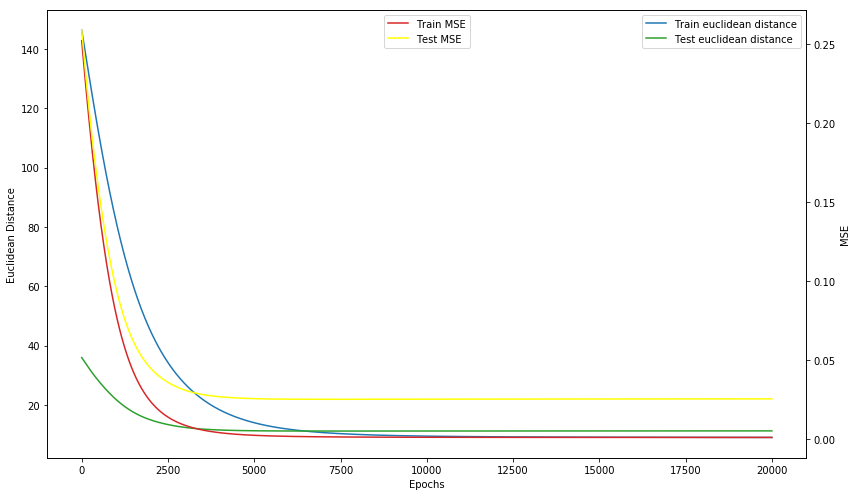

In [14]:
plot_results(training, testing, training_mse, testing_mse)

## Second: Single-Layer Perceptron
<a href="http://www.saedsayad.com/artificial_neural_network_bkp.htm">
    Dr. Saed Sayad: Artificial Neural Network - Perceptron
   <img src="http://www.saedsayad.com/images/Perceptron_bkp_1.png">
    </a>

In [15]:
graph = tf.Graph()
with graph.as_default():
    train_x = tf.placeholder(tf.float32, [None, bin_size*2])
    train_y = tf.placeholder(tf.float32, [None, bin_size])
    
    theta = tf.Variable(
        tf.random_normal(shape=[bin_size*2, bin_size])
    )
    bias = tf.Variable(
        tf.zeros(shape=[bin_size])
    )
    
    pred = tf.add(tf.matmul(train_x,theta),bias)
    loss = tf.reduce_mean(tf.norm(train_y-pred))
    mse = tf.reduce_mean(tf.losses.mean_squared_error(train_y, pred))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(mse)

In [16]:
training, testing, training_mse, testing_mse = run_session(graph)

Epoch 0
Train euclidean distance: 118.4190673828125
Train MSE: 0.16522617638111115
Test euclidean distance: 59.0324821472168
Test MSE: 0.6969667673110962
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1000
Train euclidean distance: 99.674072265625
Train MSE: 0.1170576885342598
Test euclidean distance: 52.67510223388672
Test MSE: 0.5549332499504089
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2000
Train euclidean distance: 86.05057525634766
Train MSE: 0.08724552392959595
Test euclidean distance: 48.574867248535156
Test MSE: 0.47190356254577637
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3000
Train euclidean distance: 75.81051635742188
Train MSE: 0.06771648675203323
Test euclidean distance: 45.77351760864258
Test MSE: 0.41904300451278687
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4000
Train euclidean distance: 68.2406005859375
Train MSE: 0.054868269711732864
Test euclidean distance: 43.874610900878906
Test MSE: 0.38499632477760315
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5

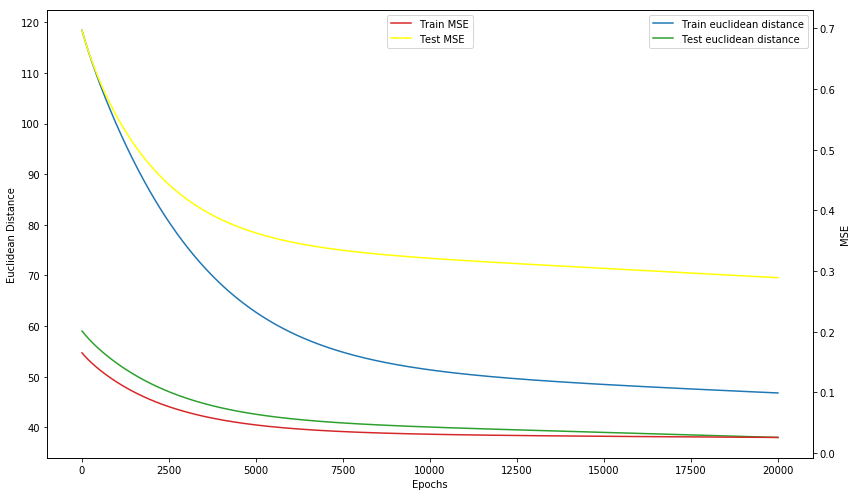

In [17]:
plot_results(training, testing, training_mse, testing_mse)

## Now let's try RNN
<a href="http://peterroelants.github.io/posts/rnn_implementation_part02/">
    Peter's notes: How to implement a recurrent neural network
<img src="https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/RNN_implementation/img/SimpleRNN02_1.png"></a>

### Let's define sequenced data
- The input is _N_ number of binary sequences each of size _n_
    - Bits are considered as timesteps.
    - _N_ is the batch size and _n_ is the number of bits we use to represent integers
- The target is the the number of 1's in each sequence, which is the sum of the sequence since it is binary

In [18]:
# def generate_sequenced_batch(batch_size=100, bin_size=8):
#     X = np.round(np.random.random((batch_size, bin_size))).astype(int)
#     Y = np.sum(X, axis=1)
#     return X,y

In [19]:
# train_X, train_Y, test_X, test_Y = generate_train_test_set()
# train_X.shape, train_Y.shape